# Sentiment Analysis
- Take last 20 of most reviews for each listing
- Calculate the sentiment scores
- Scale the sentiment scores to 0-10 for readability
- Compare results to Vader (similar)

## Import

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import dask.dataframe as dd
import pandas as pd
import numpy as np
import math
import os
import pickle
import timeit
from collections import Counter

# Graphics
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='svg'
import seaborn as sns
sns.set(font_scale=1.2)
plt.style.use('seaborn')

In [2]:
from __future__ import print_function
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from operator import itemgetter
import contractions
from langdetect import detect
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
#Plain text parsers since we are parsing through text
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.summarizers.lex_rank import LexRankSummarizer 
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer

In [4]:
os.chdir('/Users/bellepeng/Desktop/Metis/Projects/Project_AirBNB/notebooks')
import helper_functions
from helper_functions import display_topics

In [11]:
reviews_orig=pd.read_csv('/Users/bellepeng/Desktop/Metis/Projects/Project_AirBNB/data/SF/201808/reviews_201808.csv')
reviews_orig.columns
drop_list = ['reviewer_id', 'reviewer_name']
print(reviews_orig.shape)
[reviews_orig.drop(x, inplace=True, axis=1) for x in drop_list]
reviews_orig.head()

(278884, 6)


,listing_id,id,date,comments
0,958,5977,2009-07-23,"Our experience was, without a doubt, a five st..."
1,958,6660,2009-08-03,Returning to San Francisco is a rejuvenating t...
2,958,11519,2009-09-27,We were very pleased with the accommodations a...
3,958,16282,2009-11-05,We highly recommend this accomodation and agre...
4,958,26008,2010-02-13,Holly's place was great. It was exactly what I...


In [13]:
with open('/Users/bellepeng/Desktop/Metis/Projects/Project_AirBNB/data/reviews_noForeignLang.pkl', 'rb') as file:
    reviews = pickle.load(file)

print(len(reviews))
reviews[95:102]

278884


,listing_id,id,date,comments
95,958,169493237,2017-07-12,Great location and great host.
96,958,172021239,2017-07-19,"We, a family of four with two little kids, sta..."
97,958,174401034,2017-07-25,
98,958,177060286,2017-08-01,"Great place, very well located! Well furnished..."
99,958,178027423,2017-08-04,My husband and I had a wonderful stay at Holly...
100,958,180175634,2017-08-09,
101,958,180981797,2017-08-11,Very comfortable apartment with loads of priva...


## Preprocess

In [9]:
# Testing 
my_text = TextBlob("We're moving from NLTK to TextBlob. How fun!")
my_text.words
blob = TextBlob("I'm blele at speling.")
print(blob.correct())
ix=6005
print(reviews['comments'][ix])
TextBlob(reviews['comments'][ix]).sentiment

I'm belle at spelling.
We had a great stay at Kepa's. She had a lovely home and was a great host. Kepa was very helpful and the place was lovely and clean with everything we needed. Location was great with lots of restaurants a short walk away. We were very impressed with the garden, it  as nice to have such a tranquil area in an urban space. Thanks for a great stay! 


Sentiment(polarity=0.48333333333333334, subjectivity=0.6071428571428571)

## Model

In [10]:
# Calculate the sentiment score for every comment
sentiments = []
for i in range(len(reviews)):
    try:
        sentiments.append(TextBlob(reviews['comments'][i]).sentiment[0])
    except:
        sentiments.append(None)

print(len(sentiments))
sentiments[:5]

278884


[0.503125,
 0.4642857142857143,
 0.21444444444444447,
 0.26433333333333336,
 0.35375]

In [11]:
# Only about 1% have a negative sentiment
negs= [sentiments.index(x) for x in sentiments if (x and float(x)<=0)]
print(len(negs))
negs[5:15]

1637


[1996, 2603, 2975, 3147, 3555, 3646, 3719, 4829, 5250, 6112]

In [37]:
print(reviews['comments'][2975])

I stayed in a room at this property for a little over a month. The location is unbeatable, the other residents were very pleasant, and Aaron is a respectful host. My complaints: the rent was excessively high for the quality of the residence. Most surfaces in the kitchen were dirty, the floor and counters were visibly unclean. The sink in the kitchen was barely functioning. The oven and 3 out of the 4 burners on the stove were unusable. Most appliances and kitchen supplies were either old or dirty. The blanket given to me looked like it had been found on the street, and the towels provided smelled terrible. The carpet in my room was also slightly damaged and dirty. This is a fine listing if you are willing to put up with a poorly maintained dwelling. I was satisfied with my stay despite my complaints and a few misunderstandings with the landlord about policy, and would recommend it for a short stay, anything medium to long term will likely prove frustrating. 


In [16]:
# Merge sentiments back to data
reviews_w_sentiment = pd.merge(reviews, pd.DataFrame(sentiments, columns=['sentiment_score']),left_index=True, right_index=True)
reviews_w_sentiment['date']  = pd.to_datetime(reviews_w_sentiment['date']) 
len(reviews_w_sentiment)

278884

In [63]:
# Delete the lines with no comment, therefore no sentiment - about 7% dropped 260217/278884
reviews_w_sentiment=reviews_w_sentiment[reviews_w_sentiment.comments != ' ']
reviews_w_sentiment[reviews_w_sentiment['date']>='2018-01-01'].head()
len(reviews_w_sentiment)

260217

In [99]:
# Rescale to 1 to 10 - Polarity is float which lies in the range of [-1,1] 
reviews_w_sentiment['sentiment_score_scaled'] = reviews_w_sentiment['sentiment_score']*5 + 5 
reviews_w_sentiment[['sentiment_score_scaled', 'sentiment_score']].describe() 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,sentiment_score_scaled,sentiment_score
count,260217.000000,260217.000000
mean,7.101504,0.420301
std,0.931379,0.186276
min,0.000000,-1.000000
25%,6.523996,0.304799
50%,7.026042,0.405208
75%,7.595238,0.519048
max,10.000000,1.000000


In [100]:
# Keep only the 20 most recent
reviews_recent20 = reviews_w_sentiment.groupby(['listing_id']).tail(20)

In [122]:
reviews_recent20['listing_id'].unique()[-10:]

array([26788521, 26868641, 26909554, 26918300, 27084549, 27106335,
       27213403, 27237121, 27254475, 27260835])

Text(0.5,1,'Sentiment Score over Time for Listing 5858')

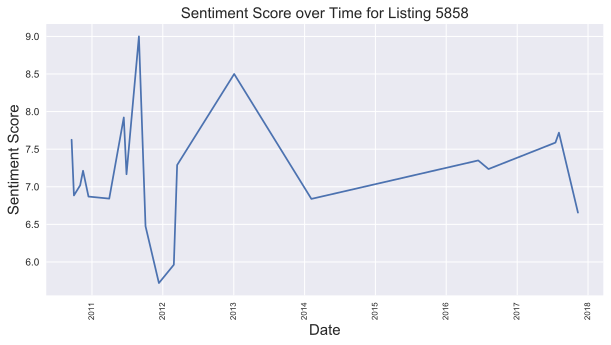

In [102]:
# Look at one listing to see if the chart works
# sub = reviews_recent20[(reviews_recent20['listing_id']==958) & (reviews_recent20['date']>='2018-01-01')]
sub = reviews_recent20[(reviews_recent20['listing_id']==8339)]
plt.figure(figsize=(10,5))
plt.plot(sub['date'], sub['sentiment_score_scaled'])
plt.xlabel('Date', size=15)
plt.ylabel('Sentiment Score', size=15)
plt.tick_params(axis='x', labelsize=8, rotation=90)
plt.title('Sentiment Score over Time for Listing 5858', size=15)

In [73]:
reviews['listing_id'].unique()[:5]

array([ 958, 5858, 7918, 8142, 8339])

In [113]:
print(reviews_recent20.shape)
reviews_recent20.head()

(74109, 6)


,listing_id,id,date,comments,sentiment_score,sentiment_score_scaled
131,958,249775050,2018-04-02,A perfect spot for a mid-to-long break. Near s...,0.330833,6.654167
132,958,252914991,2018-04-12,"We had a fantastic stay with Holly, her place ...",0.295238,6.476190
133,958,256377297,2018-04-22,Great Air BnB in a handy position in v nice su...,0.412698,7.063492
134,958,267480372,2018-05-21,Great place to stay and explore San Francisco....,0.548333,7.741667
135,958,268720981,2018-05-25,"Holly's place was great. Clean, sunny and well...",0.448958,7.244792


In [15]:
# with open('/Users/bellepeng/Desktop/Metis/Projects/Project_AirBNB/data/sentiments.pkl', 'wb') as file:
#     pickle.dump(reviews_recent20, file)
with open('/Users/bellepeng/Desktop/Metis/Projects/Project_AirBNB/data/sentiments.pkl', 'rb') as file:
    sentiments = pickle.load(file)

In [15]:
print(len(sentiments[sentiments['sentiment_score']<0.05]))
neg_sent_by_listing = sentiments[sentiments['sentiment_score']<0.05].groupby('listing_id').head(20)
neg_sent_by_listing[:5]

2504


,listing_id,id,date,comments,sentiment_score,sentiment_score_scaled
260,5858,44689509,2015-08-28,The host canceled this reservation 25 days bef...,0.000000,5.000000
275,7918,19184011,2014-09-08,The reservation was canceled the day before ar...,0.000000,5.000000
337,8567,126581919,2017-01-13,The host canceled this reservation 170 days be...,0.000000,5.000000
1330,9225,258759548,2018-04-29,"A great location, easy parking, The accommodat...",0.050000,5.250000
1333,9225,266922121,2018-05-20,This is an absolutely AMAZING space! If you ar...,0.011054,5.055272


__Consider normalizing to market average__

In [26]:
sentiments[:10]

,listing_id,id,date,comments,sentiment_score,sentiment_score_scaled
131,958,249775050,2018-04-02,A perfect spot for a mid-to-long break. Near s...,0.330833,6.654167
132,958,252914991,2018-04-12,"We had a fantastic stay with Holly, her place ...",0.295238,6.476190
133,958,256377297,2018-04-22,Great Air BnB in a handy position in v nice su...,0.412698,7.063492
134,958,267480372,2018-05-21,Great place to stay and explore San Francisco....,0.548333,7.741667
135,958,268720981,2018-05-25,"Holly's place was great. Clean, sunny and well...",0.448958,7.244792
137,958,273021917,2018-06-04,"Holly’s place is incredibly clean, cute, moder...",0.329167,6.645833
138,958,273615294,2018-06-06,We had a very comfortable and enjoyable stay i...,0.365500,6.827500
139,958,274659678,2018-06-09,This Airbnb is located in a nice and safe resi...,0.377143,6.885714
140,958,275776576,2018-06-11,Top quality property. One of the best I’ve sta...,0.553333,7.766667
141,958,278743426,2018-06-18,"This was a very pleasant, and very clean place...",0.319702,6.598512


In [25]:
print(sentiments['comments'].iloc[3])

Great place to stay and explore San Francisco. Good location, friendly owners offering clean and spacious accommodation.  Couldn’t have asked for more.


In [27]:
sentiments.groupby('listing_id')['sentiment_score'].mean()[:5]

listing_id
958     0.429255
5858    0.424641
7918    0.311719
8142    0.357073
8339    0.438755
Name: sentiment_score, dtype: float64

In [28]:
np.exp(1.6)

4.953032424395115

### Try Vader - results are similar

In [103]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [104]:
sid = SentimentIntensityAnalyzer()
for i in reviews['comments'][:3]:
    print(i)
    ss = sid.polarity_scores(i)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
        print()

Our experience was, without a doubt, a five star experience. Holly and her husband, David, were the consummate hosts; friendly and accomodating while still honoring our privacy. The apartment was a charming layout with a full view and access to the home's garden The location is perfect for full engagement with the city; close to mass transit with walking proximity to the Haight, the Mission, the Castro and Golden Gate Park. I can't wait for our next visit.

Ted and Karen Wingerd
compound: 0.959, 
neg: 0.0, 
neu: 0.788, 
pos: 0.212, 
Returning to San Francisco is a rejuvenating thrill but this time it was enhanced by our stay at Holly and David's beautifully renovated and perfectly located apartment. You do not need a car to enjoy the City as everything is within walking distance - great restaurants, bars and local stores. With such amenable hosts and a place to stay that enhances one's holiday, we will be returning again and again.
compound: 0.9819, 
neg: 0.0, 
neu: 0.697, 
pos: 0.303,

In [110]:
ss

{'neg': 0.134, 'neu': 0.71, 'pos': 0.156, 'compound': 0.76}

In [ ]:
sentiments_vader = []
for i in range(len(reviews)):
    try:
        sentiments_vader.append(TextBlob(reviews['comments'][i]).sentiment[0])
    except:
        sentiments_vader.append(None)

print(len(sentiments))
sentiments[:5]